# COVID-19 - Clinical Data to assess diagnosis


Esse projeto é uma pequena ramificação da problematica encontrada com os dados que foram disponibilizados pelo Hospital Sírio Libanês - São Paulo e Brasília, no [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)


Todo mundo sabe que a pandemia de COVID-19 atingiu o mundo inteiro, sobrecarregando os sistemas de saúde - despreparados para uma solicitação tão intensa e demorada de leitos de UTI, profissionais, equipamentos de proteção individual e recursos de saúde.

O Brasil registrou o primeiro caso COVID-19 em 26 de fevereiro e atingiu a transmissão na comunidade em 20 de março.

Há urgência na obtenção de dados precisos para melhor prever e preparar os sistemas de saúde e evitar colapsos, definidos pela necessidade de leitos de UTI acima da capacidade (presumindo-se que haja recursos humanos, EPIs e profissionais disponíveis), utilizando dados clínicos individuais - em vez de dados epidemiológicos e populacionais. <sub>traduzido e adaptado da Description do projeto no [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) - acesso: 03/08/2021
</sub>

![](../images/cdc_200313_flatten_the_curve_800x450.webp)

## O objetivo


Nosso objetivo aqui será criar um modelo capaz de prever quais pacientes precisarão ser admitidos na unidade de terapia intensiva e assim, definir qual a necessidade de leitos de UTI do hospital, a partir dos dados clínicos individuais disponíveis.

## Os dados

### Label output
A UTI (ICU) deve ser considerada, como primeira versão desse conjunto de dados, ou seja, será nossa variável de destino.

### Window Concept

Houve o cuidado de incluir cenários da vida real com janela de eventos e dados disponíveis.
Os dados foram obtidos e agrupados

 patient
- patient encounter
- aggregated by windows in chronological order

<table>
<thead>
<tr>
<th>Window</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>0-2</td>
<td>From 0 to 2 hours of the admission</td>
</tr>
<tr>
<td>2-4</td>
<td>From 2 to 4 hours of the admission</td>
</tr>
<tr>
<td>4-6</td>
<td>From 4 to 6 hours of the admission</td>
</tr>
<tr>
<td>6-12</td>
<td>From 6 to 12 hours of the admission</td>
</tr>
<tr>
<td>Above-12</td>
<td>Above 12 hours from admission</td>
</tr>
</tbody>
</table>

Não vamos usar os dados quando a variável de destino estiver presente, pois a ordem do evento é desconhecida (talvez o evento de destino tenha acontecido antes dos resultados serem obtidos). Eles foram mantidos lá para que possamos aumentar este conjunto de dados em outros resultados posteriormente.

![](../images/Best.png)

![](../images/No.png)

### Dataset
Este conjunto de dados contém dados anônimos do Hospital Sírio-Libanês, São Paulo e Brasília. Todos os dados foram tornados anônimos de acordo com as melhores práticas e recomendações internacionais.
Os dados foram limpos e escalados por coluna de acordo com Min Max Scaler para caber entre -1 e 1.

Dados baixados do https://www.kaggle.com/S%C3%ADrio-Libanes/covid19 dia 26/07/2021 e cópia salva no https://github.com/aureliowozhiak/COVID-19_Clinical-Data-to-assess-diagnosis/blob/main/dataset/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx

#### Importando bibliotecas

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings("ignore")

#### Carregando dados

In [6]:
dados = pd.read_excel('https://github.com/aureliowozhiak/COVID-19_Clinical-Data-to-assess-diagnosis/raw/main/dataset/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

#### Definindo funções

In [181]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais


def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

def roda_modelo_matriz_confusao(modelo, nome_modelo):
    
    np.random.seed(73246)
    x_columns = dados.columns
    y = dados_limpos["ICU"]
    x = dados_limpos[x_columns].drop(["ICU","WINDOW"], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
    
    modelo.fit(x_train, y_train)

    y_prediction_modelo = modelo.predict(x_test)
    print(nome_modelo + "\naccuracy_score:" , accuracy_score(y_test, y_prediction_modelo))

    plot_confusion_matrix(modelo, x_test, y_test)

    print(classification_report(y_test, y_prediction_modelo))
    
def roda_n_modelos(modelo, dados, n):

    np.random.seed(73246)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    auc_lista = []
    for _ in range(n):
        
        x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

        modelo.fit(x_train, y_train)
        prob_predic = modelo.predict_proba(x_test)
        auc = roc_auc_score(y_test, prob_predic[:,1])
        auc_lista.append(auc)
    
    auc_medio = np.mean(auc_lista)
    auc_std = np.std(auc_lista)
    print(f"AUC {auc_medio}")
    print(f"Intervalo {auc_medio - 2* auc_std} - {auc_medio + 2* auc_std}")
    
    
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(73246)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_std = np.std(resultados['test_score'])
    
    print(f'AUC Médio: {auc_medio}')
    print(f'Intervalo {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}')
    return auc_medio, auc_medio_treino

#### Limpando dados

In [85]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes

In [86]:
dados_limpos

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1900,380,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
381,1905,381,1,9,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.619048,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0-2,0
382,1910,382,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1


### Análisando a Matriz de confusão

A Matriz de confusão nos ajuda a entender as frequências de classificação para cada classe do modelo. Essas frequências são: Verdadeiro positivo, Falso positivo, Verdadeiro negativo e Falso negativo, ou seja, essa tabela permite uma visualização do desempenho dos nossos algoritmos utilizados.

Como essa matriz, temos algumas informações importantes sobre as previsões do nosso modelo:

##### accuracy (Acurácia):

% de acerto das previsões possíveis:

![](../images/accuracy.png)


##### Recall:

Proporção de positivos que foi identificado corretamente, ou seja, o quão bom o modelo é para prever positivos:

![](../images/recall.png)

##### Precision (Precisão):

Proporção de identificações positivas que foram corretas, ou seja, o quão bem o modelo trabalhou:

![](../images/precision.png)


##### f-score:

Balanço entre precisão e recall:

![](../images/fscore.png)

#### DummyClassifier

DummyClassifier
accuracy_score: 0.5340909090909091
              precision    recall  f1-score   support

           0       0.53      1.00      0.70        47
           1       0.00      0.00      0.00        41

    accuracy                           0.53        88
   macro avg       0.27      0.50      0.35        88
weighted avg       0.29      0.53      0.37        88



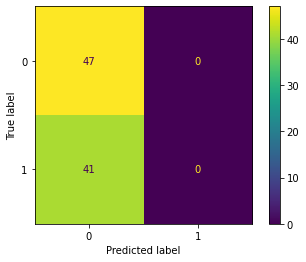

In [120]:
modelo_DummyClassifier = DummyClassifier()
roda_modelo_matriz_confusao(modelo_DummyClassifier, "DummyClassifier")

#### LogisticRegression

LogisticRegression
accuracy_score: 0.6818181818181818
              precision    recall  f1-score   support

           0       0.69      0.74      0.71        47
           1       0.68      0.61      0.64        41

    accuracy                           0.68        88
   macro avg       0.68      0.68      0.68        88
weighted avg       0.68      0.68      0.68        88



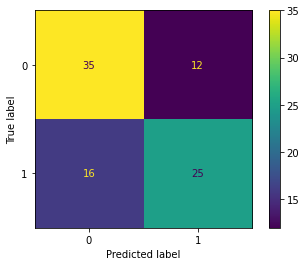

In [123]:
modelo_LogisticRegression = LogisticRegression(max_iter=10000)
roda_modelo_matriz_confusao(modelo_LogisticRegression, "LogisticRegression")

#### DecisionTreeClassifier

DecisionTreeClassifier
accuracy_score: 0.6477272727272727
              precision    recall  f1-score   support

           0       0.67      0.68      0.67        47
           1       0.62      0.61      0.62        41

    accuracy                           0.65        88
   macro avg       0.65      0.65      0.65        88
weighted avg       0.65      0.65      0.65        88



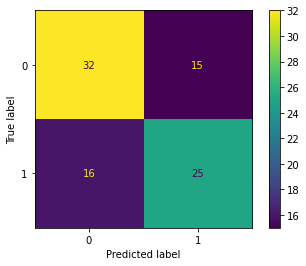

In [124]:
modelo_DecisionTreeClassifier = DecisionTreeClassifier()
roda_modelo_matriz_confusao(modelo_DecisionTreeClassifier, "DecisionTreeClassifier")

### Análisando a métrica AUC

AUC é a área entre curvas 0 e 1. Essa métrica mede o quão bem o modelo separa as classes da variável resposta baseado na sua distribuição acumulada. Valores mais próximos de 1, indicam um modelo melhor.

Para verificar essa métrica, como o modelo muda a cada vez que rodamos, vaos definir um valor comparativo de n vezes, e coletar o AUC médio e o intervalo do menor e maior valor de todas as iterações executadas.


In [158]:
print("AUC LogisticRegression média de 100x do modelo rodado")
roda_n_modelos(modelo_LogisticRegression, dados_limpos,100)

AUC LogisticRegression média de 100x do modelo rodado
AUC 0.7629994810586406
Intervalo 0.666231679922039 - 0.8597672821952421


In [159]:
print("AUC DecisionTreeClassifier média de 100x do modelo rodado")
roda_n_modelos(modelo_DecisionTreeClassifier, dados_limpos,100)

AUC DecisionTreeClassifier média de 100x do modelo rodado
AUC 0.6288687078360147
Intervalo 0.5396033655834855 - 0.7181340500885438


### Análisando com Validação Cruzada

A validação cruzada nos permite treinar e testar o modelo com todos os dados disponíveis para evitar a variância e o especto de viés nos nossos dados, com isso temos um resultado mais robusto.
Em resumo, vamos rodar o modelo várias vezes, porém a cada iteração, rodamos o modelo com uma parte do conjunto sendo para treino e outra para teste e alternamos isso até que todos os dados sejam utilizados.

![](../images/validacaocruzada.png)


#### Rodando a validação cruzada com 5 "splits" e dados embaralhados

In [155]:
cv = StratifiedKFold(n_splits = 5, shuffle = True)

In [156]:
print("Validação Cruzada com LogisticRegression")
cross_validate(modelo_LogisticRegression, x, y, cv=cv)

Validação Cruzada com LogisticRegression


{'fit_time': array([0.24400091, 0.62000179, 0.51499987, 0.60999846, 0.43300152]),
 'score_time': array([0.00499773, 0.00600076, 0.00500083, 0.006001  , 0.00500035]),
 'test_score': array([0.67605634, 0.71830986, 0.67142857, 0.72857143, 0.68571429])}

In [157]:
print("Validação Cruzada com DecisionTreeClassifier")
cross_validate(modelo_DecisionTreeClassifier, x, y, cv=cv)

Validação Cruzada com DecisionTreeClassifier


{'fit_time': array([0.0269978 , 0.02300477, 0.02500796, 0.02499509, 0.02499747]),
 'score_time': array([0.00500107, 0.00600076, 0.00600314, 0.00400186, 0.00500035]),
 'test_score': array([0.64788732, 0.67605634, 0.57142857, 0.62857143, 0.62857143])}

#### Rodando a validação cruzada com 5 "splits" porém com 10 repetições

In [162]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=10)

In [163]:
print("Validação Cruzada com LogisticRegression")
cross_validate(modelo_LogisticRegression, x, y, cv=cv)

Validação Cruzada com LogisticRegression


{'fit_time': array([0.59099603, 0.50200248, 0.17099786, 0.21099949, 0.40599966,
        0.54400086, 0.19799781, 0.50899887, 0.20699739, 0.24000263,
        0.53099918, 0.50599933, 0.5879972 , 0.55699944, 0.24500012,
        0.48500252, 0.42999935, 0.23899984, 0.52499723, 0.57900262,
        0.26599813, 0.51400065, 0.71400142, 0.83999848, 0.85899854,
        0.74099898, 0.75999856, 0.71999955, 0.56599927, 0.21399951,
        0.61600041, 0.19799972, 0.22400117, 0.55899906, 0.53900003,
        0.46299958, 0.56300092, 0.27799773, 0.61099958, 0.59899807,
        0.69399762, 0.47999907, 0.25400019, 0.55899835, 0.61799765,
        0.61399794, 0.63100004, 0.32299805, 0.16499734, 0.64699793]),
 'score_time': array([0.00499868, 0.00500035, 0.00499988, 0.00500059, 0.00500274,
        0.00399899, 0.00400209, 0.00500083, 0.00399947, 0.00399971,
        0.0040009 , 0.00500035, 0.00400233, 0.00499725, 0.00500059,
        0.00500035, 0.00499964, 0.00500035, 0.00499964, 0.00500011,
        0.00500154, 

In [164]:
print("Validação Cruzada com DecisionTreeClassifier")
cross_validate(modelo_DecisionTreeClassifier, x, y, cv=cv)

Validação Cruzada com DecisionTreeClassifier


{'fit_time': array([0.03399682, 0.02300143, 0.0229969 , 0.02499747, 0.02099705,
        0.02400064, 0.02500129, 0.02399659, 0.02099752, 0.02200031,
        0.02399826, 0.02299857, 0.02399802, 0.02099705, 0.02399969,
        0.02199674, 0.0260005 , 0.0199976 , 0.02099705, 0.02300167,
        0.02099681, 0.024997  , 0.02299547, 0.02200103, 0.02300143,
        0.02399755, 0.02199984, 0.02300143, 0.0240016 , 0.0239985 ,
        0.02599716, 0.02600265, 0.02100015, 0.02199268, 0.02190161,
        0.0239985 , 0.02399993, 0.02099943, 0.02399731, 0.02099752,
        0.02700424, 0.02099657, 0.02599883, 0.02500057, 0.01999736,
        0.02199864, 0.0220108 , 0.02699971, 0.02200031, 0.02199936]),
 'score_time': array([0.00500154, 0.00400114, 0.00600219, 0.00600314, 0.00499892,
        0.0050025 , 0.00499845, 0.00600314, 0.00400162, 0.00399637,
        0.00600195, 0.00500226, 0.00400162, 0.00700045, 0.00600362,
        0.00500035, 0.00500202, 0.00600314, 0.0040009 , 0.00500107,
        0.00521851, 

#### Tirando a média de todas essa iterações da validação cruzada

In [179]:
auc_medio, auc_medio_treino = roda_modelo_cv(modelo_LogisticRegression, dados_limpos, 5, 10)

AUC Médio: 0.7581169042846676 - AUC Médio treino: 0.8652934506326052
Intervalo 0.6363312322634126 - 0.8799025763059226


In [178]:
auc_medio, auc_medio_treino = roda_modelo_cv(modelo_DecisionTreeClassifier, dados_limpos, 5, 10)

AUC Médio: 0.6279279683391525 - AUC Médio treino: 1.0
Intervalo 0.4988394445682657 - 0.7570164921100394
